# AIsteroid
[http://bit.ly/aisteroid](http://bit.ly/aisteroid)

In [1]:
from aisteroid import *
%matplotlib nbagg

## Task: Detect moving objects

In [2]:
if QIPY:
    ### Choose the image set
    #CONF.SET="example" ##Choose your preferred imageset
    #CONF.CFG="example" ##You choose your preferred observatory configuration (example.cfg)
    CONF.OVERWRITE=1 ##Overwrite all previous actions
    CONF.VERBOSE=1 ## Show all outputs
    #CONF.SET="ps1-20180107_1_set045"
    CONF.SET="ps1-20180108_2_set199"

#### DO NOT TOUCH IF YOU ARE NOT SURE

In [3]:
#DO NOT MODIFY THIS LINES
print0("*"*60+"\nMOVING SOURCES FOR SET '%s'\n"%CONF.SET+"*"*60)

OUT_DIR=CONF.SCR_DIR+CONF.SET+"/"
if not os.path.isdir(OUT_DIR):
    error("Set '%s' has not been unpacked"%CONF.SET)
    
CFG=[line.rstrip('\n') for line in open(CONF.SETS_DIR+CONF.CFG+".cfg")]

PLOT_DIR=OUT_DIR+"plots/"
FLOG=open(OUT_DIR+"detect.log","a")
SYSOPTS=dict(qexit=[True,FLOG])

AIA_FILE=OUT_DIR+CONF.SET+".aia"
if not os.path.isfile(AIA_FILE):
    error("Extract task not ran yet on set '%s'"%CONF.SET)
else:
    AIA=pickle.load(open(AIA_FILE,"rb"))
    images=AIA["images"]
    sources=AIA["sources"]
    nimgs=len(images)

************************************************************
MOVING SOURCES FOR SET 'ps1-20180108_2_set199'
************************************************************


### Detect potential moving objects

In [4]:
print0("Potential moving objects")
print1("\tSearching RADIUS (pixels, arcsec):",CONF.RADIUS)
RADIUS=CONF.RADIUS

if len(sources[sources.NIMG>1])==0 or CONF.OVERWRITE:
    iobj=1
    for i,ind in enumerate(sources.index):
        obj=sources.loc[ind]
        x=obj.X_ALIGN;y=obj.Y_ALIGN
        if obj.NIMG>1:continue

        #COMPUTE THE EUCLIDEAN DISTANCE TO ALL OBJECTS NOT FOUND YET
        cond=sources.NIMG==1
        searchobjs=sources[cond]
        ds=((x-searchobjs.X_ALIGN)**2+(y-searchobjs.Y_ALIGN)**2).apply(np.sqrt)

        #IN HOW MANY IMAGES THE OBJECT IS PRESENT
        cond=ds<RADIUS
        inds=searchobjs[cond].index
        nimg=len(sources.ix[inds])
        sources.loc[inds,"NIMG"]=nimg

        #ASSIGN OBJECT NUMBER
        if nimg==4:
            sources.loc[inds,"OBJ"]=iobj
            iobj+=1
    
    AIA["sources"]=sources
    pickle.dump(AIA,open(AIA_FILE,"wb"))
else:
    print("\tMoving objetcs already detected")
    sources=AIA["sources"]
    
moving=sources[sources.NIMG<2]
rest=sources[sources.NIMG>=2]    
print0("\tNumber of potentially moving objects: ",len(moving))
print0("\tDone.")
FLOG.write("Potential moving objects: %d\n"%(len(moving)))
FLOG.flush()

Potential moving objects
	Searching RADIUS (pixels, arcsec): 3
	Number of potentially moving objects:  200
	Done.


### Show potential moving objects

Showing potential moving sources
	Done.


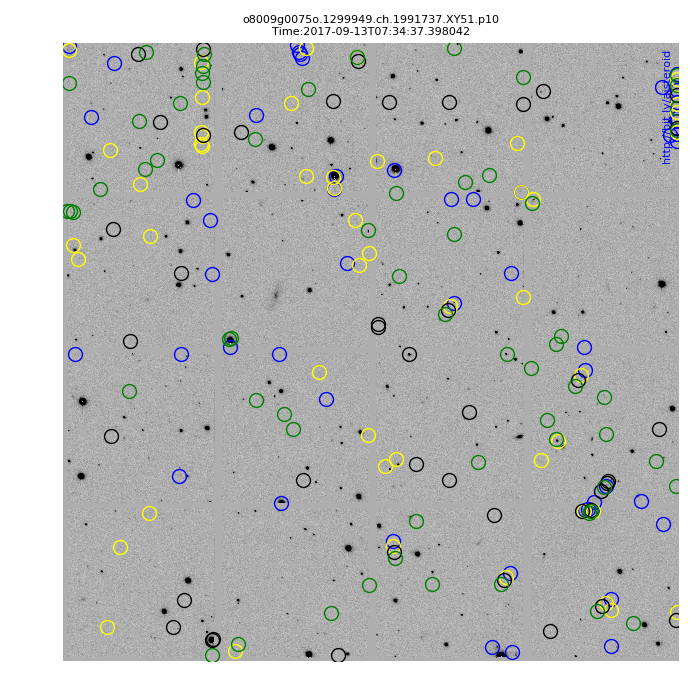

In [6]:
plotfile=PLOT_DIR+"moving-%s.png"%CONF.SET

if CONF.QPLOT:
    plt.ioff() ##Comment to see interactive figure

    print0("Showing potential moving sources")
    if not os.path.isfile(plotfile) or CONF.OVERWRITE:

        
        iimg=0
        image=images[iimg]

        fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
        ax=axs
        imgargs=dict(cmap='gray_r',vmin=0,vmax=500)
        ax.imshow(image["data"],**imgargs)       
        ax.axis("off")
        itime=image["header"]["DATE-OBS"]
        ax.set_title(image["file"]+"\n"+"Time:"+itime,fontsize=8,position=(0.5,1.0))

        #Show the sources
        gray=plt.get_cmap('gray')
        #ax.plot(moving["X_IMAGE"]-1,moving["Y_IMAGE"],'bo',ms=10,mfc='None',alpha=0.2)

        colors=['blue','yellow','black','green']
        for i in range(nimgs):
            ax.plot(moving.loc[moving.IMG==i,"X_IMAGE"]-1,moving.loc[moving.IMG==i,"Y_IMAGE"],
                    'o',color=colors[i%4],ms=10,mfc='None',alpha=1.0)
        
        fig.tight_layout()
        waterMark(axs)
        fig.savefig(plotfile)
    else:
        if CONF.QPLOT:print0("\tImage '%s' already generated."%plotfile)
    print0("\tDone.")
Image(filename=plotfile)

### Detect asteroids

In [8]:
#Numbers
print0("Searching for asteroids")
nrule=0
if not "objects" in AIA.keys() or CONF.OVERWRITE:
    nmax=nimgs-3
    ix="X_ALIGN"
    iy="Y_ALIGN"

    #Layers and times
    ninds=[]
    layers=[]
    dts=np.zeros((nimgs,nimgs))
    for i in range(nimgs):
        images[i]["unixtime"]=date2unix(images[i]["obstime"])
    for i in range(nimgs):
        image=images[i]
        layers+=[moving[moving.IMG==i].sort_values(by=['X_ALIGN','Y_ALIGN'])]
        ninds+=[len(layers[-1])]
        for j in range(len(images)):
            dts[i,j]=images[j]["unixtime"]-images[i]["unixtime"]

    #Ranges
    xmax=max(sources.X_ALIGN);xmin=min(sources.X_ALIGN)
    ymax=max(sources.Y_ALIGN);ymin=min(sources.Y_ALIGN)

    ntot=ninds[0]*(ninds[1]+ninds[2])+ninds[1]*(ninds[2]+ninds[3])+ninds[2]*ninds[3]
    print1("Estimated number of rulers:",ntot)
    FLOG.write("Estimated number of rulers: %d\n"%(ntot))
    print1("Times between images:")

    dobj=[]
    mobj=1

    objects=[]
    for ind in sources.index:sources.loc[ind,"MOBJ"]=0
    moving=sources[sources.NIMG<2]
    for i in range(nimgs):
        print1("Layer %d:"%i)
        ref=layers[i]
        sizey,sizex=images[i]["data"].shape
        print1("\tNumber of sources:",len(ref))
        for j in range(i+1,nimgs):
            if i==j:continue
            print1("\tKick layer %d:"%j)
            kic=layers[j]
            print1("\t\tNumber of sources:",len(kic))
            dt=dts[i,j]
            print1("\t\tTime between layers:",dt)

            #Create rulers
            for indr in ref.index[:]:
                
                if moving.loc[indr,"MOBJ"]>0:continue
                rulers=[]
                for indk in kic.index:
                    if moving.loc[indk,"MOBJ"]>0:continue
                    vx=(kic.loc[indk,ix]-ref.loc[indr,ix])/dt
                    vy=(kic.loc[indk,iy]-ref.loc[indr,iy])/dt

                    d=np.sqrt((vx*dt)**2+(vy*dt)**2)

                    #If contiguous object is too close it may be an error
                    if d<10*CONF.RADIUS:continue

                    #If contiguous object is too far it may be an error
                    if d>sizex/CONF.MAXMOTION:continue
                        
                    ruler=[]
                    for k in range(nimgs):
                        ruler+=[[images[k]["unixtime"],
                                 ref.loc[indr,ix]+vx*dts[i,k],
                                 ref.loc[indr,iy]+vy*dts[i,k],
                                 ref.loc[indr,"MAG_ASTRO"]]]
                    ruler=np.array(ruler)
                    if ((ruler[:,1]>xmax)|(ruler[:,1]<xmin)).sum()>nmax or \
                        ((ruler[:,2]>ymax)|(ruler[:,2]<ymin)).sum()>nmax:
                        continue
                    
                    rulers+=[ruler]
                    nrule+=1
                    
                    #Match
                    hits=np.zeros(4)
                    objs=-1*np.ones(4)
                    for k in range(nimgs):
                        if k==i:
                            hits[k]=1
                            objs[k]=indr
                        if k==j:
                            hits[k]=1    
                            objs[k]=indk
                        else:
                            ds=((ruler[k,1]-moving.loc[(moving.IMG==k)&(moving.MOBJ==0),ix])**2+(ruler[k,2]-moving.loc[(moving.IMG==k)&(moving.MOBJ==0),iy])**2).apply(np.sqrt)
                            if ds.min()<CONF.RADIUS:
                                hits[k]=1
                                objs[k]=ds.idxmin()
                    if hits.sum()>=3:
                        print1("\t\t\tObject %d detected"%mobj)
                        print1("\t\t\tObject indexes:",objs)

                        #Plot line
                        points=[]
                        mags=[]
                        xs=[]
                        ys=[]
                        impoints=[]
                        for ind in objs:
                            if ind<0:continue
                            points+=[moving.loc[ind,[ix,iy]].values]
                            impoints+=[moving.loc[ind,"IMG"]]
                            mags+=[moving.loc[ind,"MAG_BEST"]]
                            xs+=[moving.loc[ind,"X_IMAGE"]]
                            ys+=[moving.loc[ind,"Y_IMAGE"]]
                            print1("\t\t\t\tMag %d = %.1f"%(ind,mags[-1]))

                        points=np.array(points)
                        magvar=np.array(mags).std()
                        xvar=np.array(xs).std()
                        yvar=np.array(ys).std()

                        print1("\t\t\t\tCoordinate variance (%.2f) = "%CONF.RADIUS,xvar,yvar)
                        if xvar<CONF.RADIUS or yvar<CONF.RADIUS:
                            print1("\t\t\t\t***Object rejected by coordinate variance***")
                            continue

                        print1("\t\t\t\tMag variance = %.2f"%(magvar))
                        if magvar>CONF.MAGVAR:
                            print1("\t\t\t\t***Object rejected by magnitude variance***")
                            continue

                        print0("\t\t\t\tObject %d detected"%mobj)
                        sources.loc[objs[objs>0].tolist(),"MOBJ"]=mobj
                        objects+=[objs]

                        moving=sources[sources.NIMG<2]
                        
                        mobj+=1

    print1("\tNumber of useful rulers: %d"%(nrule))
    FLOG.write("Number of useful rulers: %d\n"%(nrule))

    #Compile information about detected objects 
    indxs=sources[sources.MOBJ>0].index
    mobjs=np.unique(sources.MOBJ.values)
    nobj=len(mobjs[mobjs>0])

    #Store objects
    AIA["sources"]=sources
    AIA["objects"]=objects
    pickle.dump(AIA,open(AIA_FILE,"wb"))

else:
    print("\tObjects already detected.")
    AIA=pickle.load(open(AIA_FILE,"rb"))
    objects=AIA["objects"]
    sources=AIA["sources"]
    nobj=len(objects)
    moving=sources[sources.NIMG<2]
    rest=sources[sources.NIMG>=2]
    indxs=moving[moving.MOBJ>0].index
    mobjs=np.unique(moving.MOBJ.values)
    
print0("\tNumber of detected objects:",nobj)
print0("\tDone.")
FLOG.write("Total detected objects: %d\n"%(nobj))
FLOG.write("Objects: %s\n"%(str(indxs)))
FLOG.flush()

Searching for asteroids
Estimated number of rulers: 12909
Times between images:
Layer 0:
	Number of sources: 52
	Kick layer 1:
		Number of sources: 51
		Time between layers: 1176.27116203
	Kick layer 2:
		Number of sources: 43
		Time between layers: 2351.26873207
			Object 1 detected
			Object indexes: [ 1145.  1352.  1404.  1589.]
				Mag 1145 = -9.5
				Mag 1352 = -9.1
				Mag 1404 = -9.0
				Mag 1589 = -8.8
				Coordinate variance (3.00) =  4.37186583106 25.2043779211
				Mag variance = 0.25
	Object 1 detected
			Object 2 detected
			Object indexes: [ 762.  835.  820.  800.]
				Mag 762 = -10.2
				Mag 835 = -10.1
				Mag 820 = -10.1
				Mag 800 = -10.1
				Coordinate variance (3.00) =  13.3637628605 15.4911923632
				Mag variance = 0.05
	Object 2 detected
			Object 3 detected
			Object indexes: [ 1745.  2174.  2095.  2223.]
				Mag 1745 = -8.6
				Mag 2174 = -8.1
				Mag 2095 = -8.1
				Mag 2223 = -8.0
				Coordinate variance (3.00) =  13.8001118022 16.3458164296
				Mag variance =

### Show detected objects

Showing objects in overly
	Done.


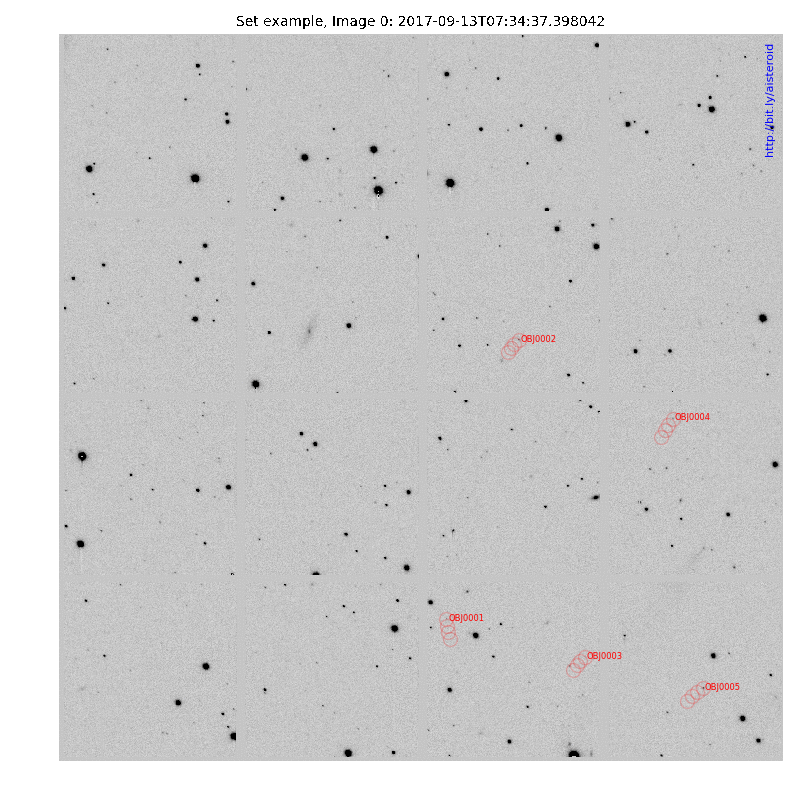

In [9]:
plotfile=PLOT_DIR+"objects-%s.gif"%CONF.SET
if CONF.QPLOT and nobj>0:
    plt.ioff() ##Comment to see interactive figure

    print("Showing objects in overly")
    if not os.path.isfile(plotfile) or CONF.OVERWRITE:

        #Figure
        fig=plt.figure(figsize=(8,8))

        #Show first image
        imgargs=dict(cmap='gray_r',vmin=0,vmax=700)
        im=plt.imshow(images[0]["data"],animated=True,**imgargs)

        #Title
        tm=plt.title("Set %s, Image 0: "%CONF.SET+images[0]["obstime"],fontsize=10)

        #Water mark
        waterMark(fig.gca())

        #Show detected objects
        for mobj in range(1,nobj+1):
            cond=moving.loc[indxs].MOBJ==mobj
            inds=moving.loc[indxs].index[cond]
            idobj="%s%04d"%("OBJ",mobj)
            n=1
            for ind in inds:
                obj=moving.loc[ind]
                plt.plot(obj.X_IMAGE-1,obj.Y_IMAGE-1,'ro',ms=10,mfc='None',alpha=0.2)
                if n==1:
                    plt.text(obj.X_IMAGE+5,obj.Y_IMAGE+5,"%s"%idobj,color='r',fontsize=6)
                n+=1

        #Basic decoration
        plt.axis("off")
        fig.tight_layout()

        #Update figure
        def updatefig(i):
            #Select image
            iimg=i%nimgs
            im.set_array(images[iimg]["data"])
            tm.set_text("Set %s, Image %d: "%(CONF.SET,iimg)+images[iimg]["obstime"])
            return im,


        #Create animation
        ani=animation.FuncAnimation(fig,updatefig,frames=range(nimgs),
                                    interval=1000,repeat_delay=1000,
                                    repeat=True,blit=True)
        time.sleep(1)
        saveAnim(ani,PLOT_DIR,plotfile)
    else:
        if CONF.QPLOT:print0("\tImage '%s' already generated."%plotfile)
    print0("\tDone.")
Image(filename=plotfile)

### Save object

In [18]:
if nobj>0:
    print0("\tReporting objects")
    fo=open(OUT_DIR+"objects.log","w")
    fo.write("Set: %s\n"%CONF.SET)
    fo.write("Number of objects: %d\n"%nobj)
    fo.write("Objects: %s"%str(objects))

	Reporting objects


In [19]:
print("Task completed.")
FLOG.close()

Task completed.
